In [2]:
from math import log2
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


# Seed everything
Let's seed everything to make results somewhat reproducible

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

### Hyperparameters





In [4]:
#Initialize the DATASET by the path of the real images.
DATASET                 = "Root"

#Specify the start train at image size four by four as the paper.
START_TRAIN_AT_IMG_SIZE = 4

#Initialize the device by Cuda if it is available and CPU otherwise, and learning rate by 0.001.
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE           = 1e-3

#The batch size will be different depending on the resolution of the images that we want to generate, so we initialize BATCH_SIZES by a list of numbers, you can change them depending on your VRAM.
BATCH_SIZES             = [32, 32, 32, 16, 16, 16]

#Initialize image_size by 128 and CHANNELS_IMG by 3 because we will generate 128  by 128 RGB images.
image_size              = 128
CHANNELS_IMG            = 3

#In the original paper, they initialize Z_DIM and IN_CHANNELS by 512, but I initialize them by 256 instead for less VRAM usage and speed-up training. We could perhaps even get better results if we doubled them.
Z_DIM                   = 256  
IN_CHANNELS             = 256  
CRITIC_ITERATIONS       = 1

#For ProGAN we can use any of the GANs loss functions we want but we are looking to follow the paper exactly, so we will use the same loss function as they used the Wasserstein loss function, also known as WGAN-GP from the paper Improved Training of Wasserstein GANs. This loss contains a parameter name λ and it's common to set λ = 10.
LAMBDA_GP               = 10

#Initialize PROGRESSIVE_EPOCHS by 30 for each image size.
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)
FIXED_NOISE             = torch.randn(9, Z_DIM, 1, 1).to(DEVICE)

### Get and check the Data loader


In [5]:
def get_loader(image_size):
    #Apply some transformation to the images (resize the images to the resolution that we want, convert them to tensors, then apply some augmentation, and finally normalize them to be all the pixels ranging from -1 to 1).
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    #Identify the current batch size using the list BATCH_SIZES, and take as an index the integer number of the inverse representation of the power of 2 of image_size/4. And this is actually how we implement the adaptive minibatch size depending on the output resolution.
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset


### Now let's check if everything works fine and see what the real images look like.



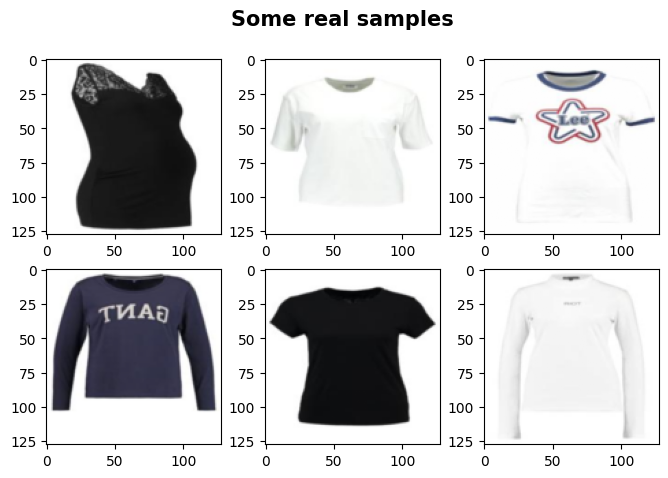

In [6]:
def check_loader():
    loader,_ = get_loader(image_size)
    cloth ,_ = next(iter(loader))
    _, ax = plt.subplots(2,3, figsize=(8,5))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(2):
        for kk in range(3):
            
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 
            ind += 1
check_loader()

### Models implementation
- Progressive growing (of model and layers)
- Minibatch std on Discriminator
- Normalization with PixelNorm
- Equalized Learning Rate

<img src="https://blog.paperspace.com/content/images/2022/08/image-61.png" alt="Image 61">


<p>In the figure above, we can see the architecture of the generator. For the number of channels, we have 512 (256 in our case) four-time, <br>
then we decrease it by 1/2, 1/4, etc. Let's define a variable with the name factors which will be used in Discrmininator and Generator for <br>
how much the channels should be multiplied and expanded for each layer.</P>

In [7]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

### Equalized Learning Rate
Now let's implement Equalized Learning Rate for the generator, let's name the class WSConv2d (weighted scaled convolutional layer) which will be inherited from nn.Module.

In the init part we send in_channels, out_channels, kernel_size, stride, and padding. We use all of that to do a normal Conv layer, then we define a scale that will<br> be the same as the function part2 in the figure below, we copy the bias of the current column layer into a variable because we don't want the bias of the convolution layer to be scaled,<br> then we remove it, Finally, we initialize conv layer.  

<img src="https://blog.paperspace.com/content/images/2022/08/1_BPlvFpOxiY4RQGp3Xdls1Q-1-2.png" alt="Image 62">


In [8]:

# This class implements a convolutional layer with weight scaling. Weight scaling is a technique to normalize the weights during initialization. The forward method performs the convolution operation.
class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


### Normalization with PixelNorm
Now let's create a class for PixelNorm, for normalization.

In the init part we define epsilon by 10^-8.
In the forward part, we send x, and we return the same as the function in the figure below.

<img src="https://blog.paperspace.com/content/images/size/w1000/2022/08/image-57-1.png" alt="Image 62">

In [9]:
# This class implements pixel-wise feature vector normalization. It normalizes each pixel's feature vector across the channels.
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


# ConvBlock

- In the init part we send in_channels, out_channels, and use_pixelnorm, then we initialize conv1 by WSConv2d which maps in_channels to out_channels, <br>conv2 by WSConv2d which maps out_channels to out_channels, leaky by Leaky ReLU with a slope of 0.2 as they use in the paper, pn by PixelNorm(The last block that we create), and  use_pn by use_pixelnorm to specify if we are using PixelNorm or not.
- In the forward part, we send x, and we pass it to conv1 with leaky, then we normalize it with pn (PixelNorm) if use_pixelnorm is True, otherwise, <br>we don't, and again we pass that into conv2 with leaky and we normalize it if use_pixelnorm is True. Finally, we return x.

In [11]:
# This class defines a block of convolutional layers followed by leaky ReLU activation and pixel normalization.
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

### Let's begin by building the generator.

<img src="https://blog.paperspace.com/content/images/2022/08/image-61.png" alt="Image 61">


In [ ]:
class Generator(nn.Module):
    #  z_dim (dimension of the input noise vector z), in_channels (number of input channels for the initial convolution), and img_channels (number of channels in the generated images, typically 3 for RGB images).
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )
# The progressive blocks are created based on the factors defined outside the class. These factors determine the growth of feature map resolutions.
        for i in range(
            len(factors) - 1
        ):  
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )
# The fade_in method blends between two images (upscaled and generated) using a linear interpolation controlled by the parameter alpha. This is used during the transition between different resolution stages.
#To fade in new layers (a component of ProGAN), we add the fade_in part, which we send alpha, scaled, and generated, and we return  
# ---------------------------------------------
# |  tanh(alpha∗generated+(1−alpha)∗upscale)  |
# ---------------------------------------------         
#The reason why we use tanh is that will be the output(the generated image) and we want the pixels to be range between 1 and -1.
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)


### Discriminator
we are using WGAN-GP. 


<img src="https://blog.paperspace.com/content/images/2022/08/image-62.png" alt="Image 61">


In [10]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)


        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  
        self.final_block = nn.Sequential(
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ), 
        )
#To fade in new layers (a component of ProGAN), we add the fade_in part, which we send alpha, scaled, and generated, and we return  
# ---------------------------------------------
# |  tanh(alpha∗generated+(1−alpha)∗upscale)  |
# ---------------------------------------------         
#The reason why we use tanh is that will be the output(the generated image) and we want the pixels to be range between 1 and -1.
    def fade_in(self, alpha, downscaled, out):

        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )

        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):

        cur_step = len(self.prog_blocks) - steps


        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)


        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))


        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

### WGAN-GP loss
In the code snippet below you can find the gradient_penalty function for WGAN-GP loss.

In [38]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [39]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [40]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )
        

    return alpha


In [41]:
gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()




gen.train()
critic.train()

tensorboard_step = 0
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5  
    loader, dataset = get_loader(4 * 2 ** step)  
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
        )
    generate_examples(gen, step, n=100)


    step += 1  

Current image size: 4
Epoch [1/30]


100%|██████████| 508/508 [02:00<00:00,  4.21it/s, gp=0.021, loss_critic=-0.591]  


Epoch [2/30]


100%|██████████| 508/508 [00:19<00:00, 25.50it/s, gp=0.00732, loss_critic=-0.671]


Epoch [3/30]


100%|██████████| 508/508 [00:19<00:00, 25.92it/s, gp=0.00912, loss_critic=-0.178] 


Epoch [4/30]


100%|██████████| 508/508 [00:18<00:00, 26.94it/s, gp=0.00928, loss_critic=-0.116]  


Epoch [5/30]


100%|██████████| 508/508 [00:19<00:00, 26.71it/s, gp=0.00507, loss_critic=-0.0771] 


Epoch [6/30]


100%|██████████| 508/508 [00:19<00:00, 26.66it/s, gp=0.00957, loss_critic=-0.0778] 


Epoch [7/30]


100%|██████████| 508/508 [00:19<00:00, 26.48it/s, gp=0.00654, loss_critic=-0.0672] 


Epoch [8/30]


100%|██████████| 508/508 [00:16<00:00, 30.76it/s, gp=0.00438, loss_critic=-0.277]  


Epoch [9/30]


100%|██████████| 508/508 [00:16<00:00, 31.45it/s, gp=0.00486, loss_critic=0.0476]   


Epoch [10/30]


100%|██████████| 508/508 [00:16<00:00, 31.63it/s, gp=0.00964, loss_critic=-0.138]   


Epoch [11/30]


100%|██████████| 508/508 [00:16<00:00, 30.55it/s, gp=0.00608, loss_critic=-0.0337]  


Epoch [12/30]


100%|██████████| 508/508 [00:17<00:00, 29.23it/s, gp=0.008, loss_critic=-0.059]     


Epoch [13/30]


100%|██████████| 508/508 [00:18<00:00, 26.75it/s, gp=0.0115, loss_critic=-0.00685]  


Epoch [14/30]


100%|██████████| 508/508 [00:18<00:00, 26.75it/s, gp=0.0055, loss_critic=-0.278]    


Epoch [15/30]


100%|██████████| 508/508 [00:19<00:00, 26.32it/s, gp=0.0144, loss_critic=-0.0926]  


Epoch [16/30]


100%|██████████| 508/508 [00:19<00:00, 26.63it/s, gp=0.00418, loss_critic=-0.0627]  


Epoch [17/30]


100%|██████████| 508/508 [00:18<00:00, 26.80it/s, gp=0.00589, loss_critic=-0.0619] 


Epoch [18/30]


100%|██████████| 508/508 [00:18<00:00, 27.09it/s, gp=0.00816, loss_critic=-0.0399]  


Epoch [19/30]


100%|██████████| 508/508 [00:19<00:00, 26.72it/s, gp=0.0022, loss_critic=-0.0338]   


Epoch [20/30]


100%|██████████| 508/508 [00:17<00:00, 28.39it/s, gp=0.0107, loss_critic=0.0194]   


Epoch [21/30]


100%|██████████| 508/508 [00:19<00:00, 25.82it/s, gp=0.00535, loss_critic=0.118]    


Epoch [22/30]


100%|██████████| 508/508 [00:20<00:00, 25.34it/s, gp=0.00611, loss_critic=-0.00315]


Epoch [23/30]


100%|██████████| 508/508 [00:20<00:00, 24.94it/s, gp=0.00678, loss_critic=0.0596]   


Epoch [24/30]


100%|██████████| 508/508 [00:20<00:00, 24.86it/s, gp=0.00667, loss_critic=-0.091]   


Epoch [25/30]


100%|██████████| 508/508 [00:19<00:00, 26.12it/s, gp=0.00303, loss_critic=-0.227]   


Epoch [26/30]


100%|██████████| 508/508 [00:20<00:00, 24.76it/s, gp=0.00607, loss_critic=-0.0528] 


Epoch [27/30]


100%|██████████| 508/508 [00:20<00:00, 24.41it/s, gp=0.00452, loss_critic=-0.0635]  


Epoch [28/30]


100%|██████████| 508/508 [00:20<00:00, 25.31it/s, gp=0.00407, loss_critic=-0.486]   


Epoch [29/30]


100%|██████████| 508/508 [00:19<00:00, 25.53it/s, gp=0.00927, loss_critic=0.0903]  


Epoch [30/30]


100%|██████████| 508/508 [00:20<00:00, 25.33it/s, gp=0.00643, loss_critic=0.0377]   


Current image size: 8
Epoch [1/30]


100%|██████████| 508/508 [00:28<00:00, 17.89it/s, gp=0.00256, loss_critic=0.192]   


Epoch [2/30]


100%|██████████| 508/508 [00:27<00:00, 18.18it/s, gp=0.00576, loss_critic=0.135]    


Epoch [3/30]


100%|██████████| 508/508 [00:27<00:00, 18.20it/s, gp=0.00636, loss_critic=-0.627]   


Epoch [4/30]


100%|██████████| 508/508 [00:28<00:00, 17.92it/s, gp=0.00996, loss_critic=0.517]   


Epoch [5/30]


100%|██████████| 508/508 [00:27<00:00, 18.22it/s, gp=0.0139, loss_critic=-0.00345]  


Epoch [6/30]


100%|██████████| 508/508 [00:27<00:00, 18.28it/s, gp=0.00482, loss_critic=-0.0844] 


Epoch [7/30]


100%|██████████| 508/508 [00:28<00:00, 17.62it/s, gp=0.00903, loss_critic=0.168]   


Epoch [8/30]


100%|██████████| 508/508 [00:28<00:00, 17.68it/s, gp=0.00636, loss_critic=-0.243]  


Epoch [9/30]


100%|██████████| 508/508 [00:29<00:00, 17.50it/s, gp=0.00457, loss_critic=-0.0262]  


Epoch [10/30]


100%|██████████| 508/508 [00:29<00:00, 17.49it/s, gp=0.00264, loss_critic=0.101]    


Epoch [11/30]


100%|██████████| 508/508 [00:29<00:00, 17.33it/s, gp=0.0044, loss_critic=-0.426]    


Epoch [12/30]


100%|██████████| 508/508 [00:28<00:00, 17.87it/s, gp=0.00554, loss_critic=-0.104]   


Epoch [13/30]


100%|██████████| 508/508 [00:27<00:00, 18.28it/s, gp=0.00561, loss_critic=0.195]    


Epoch [14/30]


100%|██████████| 508/508 [00:27<00:00, 18.28it/s, gp=0.00559, loss_critic=-0.443]   


Epoch [15/30]


100%|██████████| 508/508 [00:29<00:00, 17.34it/s, gp=0.00422, loss_critic=-0.0468]  


Epoch [16/30]


100%|██████████| 508/508 [00:29<00:00, 17.22it/s, gp=0.00546, loss_critic=0.031]   


Epoch [17/30]


100%|██████████| 508/508 [00:30<00:00, 16.89it/s, gp=0.00665, loss_critic=-0.0461] 


Epoch [18/30]


100%|██████████| 508/508 [00:32<00:00, 15.85it/s, gp=0.00658, loss_critic=0.0692]   


Epoch [19/30]


100%|██████████| 508/508 [00:29<00:00, 17.32it/s, gp=0.011, loss_critic=0.0751]     


Epoch [20/30]


100%|██████████| 508/508 [00:25<00:00, 19.97it/s, gp=0.00431, loss_critic=0.185]   


Epoch [21/30]


100%|██████████| 508/508 [00:27<00:00, 18.60it/s, gp=0.00681, loss_critic=0.127]    


Epoch [22/30]


100%|██████████| 508/508 [00:27<00:00, 18.16it/s, gp=0.00398, loss_critic=0.0466]  


Epoch [23/30]


100%|██████████| 508/508 [00:25<00:00, 19.91it/s, gp=0.00611, loss_critic=-0.0226] 


Epoch [24/30]


100%|██████████| 508/508 [00:25<00:00, 20.02it/s, gp=0.00504, loss_critic=-0.479]   


Epoch [25/30]


100%|██████████| 508/508 [00:28<00:00, 17.93it/s, gp=0.00388, loss_critic=0.0844]   


Epoch [26/30]


100%|██████████| 508/508 [00:27<00:00, 18.30it/s, gp=0.00627, loss_critic=0.0916]  


Epoch [27/30]


100%|██████████| 508/508 [00:27<00:00, 18.40it/s, gp=0.00455, loss_critic=-0.0235] 


Epoch [28/30]


100%|██████████| 508/508 [00:28<00:00, 17.71it/s, gp=0.00346, loss_critic=0.473]    


Epoch [29/30]


100%|██████████| 508/508 [00:28<00:00, 17.98it/s, gp=0.0075, loss_critic=-0.164]    


Epoch [30/30]


100%|██████████| 508/508 [00:28<00:00, 17.87it/s, gp=0.00318, loss_critic=-0.174]   


Current image size: 16
Epoch [1/30]


100%|██████████| 508/508 [01:06<00:00,  7.69it/s, gp=0.0017, loss_critic=-0.204]    


Epoch [2/30]


100%|██████████| 508/508 [01:05<00:00,  7.70it/s, gp=0.00569, loss_critic=0.102]  


Epoch [3/30]


100%|██████████| 508/508 [01:05<00:00,  7.74it/s, gp=0.00374, loss_critic=-0.364]  


Epoch [4/30]


100%|██████████| 508/508 [01:06<00:00,  7.66it/s, gp=0.00603, loss_critic=-0.585]  


Epoch [5/30]


100%|██████████| 508/508 [01:06<00:00,  7.69it/s, gp=0.00274, loss_critic=-0.177]   


Epoch [6/30]


100%|██████████| 508/508 [01:04<00:00,  7.89it/s, gp=0.00504, loss_critic=0.19]    


Epoch [7/30]


100%|██████████| 508/508 [01:04<00:00,  7.82it/s, gp=0.00539, loss_critic=0.517]    


Epoch [8/30]


100%|██████████| 508/508 [01:06<00:00,  7.64it/s, gp=0.00718, loss_critic=-0.229]  


Epoch [9/30]


100%|██████████| 508/508 [01:05<00:00,  7.72it/s, gp=0.00645, loss_critic=-0.307] 


Epoch [10/30]


100%|██████████| 508/508 [01:06<00:00,  7.69it/s, gp=0.00577, loss_critic=-0.137]  


Epoch [11/30]


100%|██████████| 508/508 [01:06<00:00,  7.69it/s, gp=0.00547, loss_critic=-0.307]  


Epoch [12/30]


100%|██████████| 508/508 [01:05<00:00,  7.76it/s, gp=0.00528, loss_critic=-0.735]  


Epoch [13/30]


100%|██████████| 508/508 [01:05<00:00,  7.78it/s, gp=0.00284, loss_critic=-0.545]  


Epoch [14/30]


100%|██████████| 508/508 [01:05<00:00,  7.78it/s, gp=0.0132, loss_critic=0.141]    


Epoch [15/30]


100%|██████████| 508/508 [01:05<00:00,  7.78it/s, gp=0.00355, loss_critic=-0.42]   


Epoch [16/30]


100%|██████████| 508/508 [01:03<00:00,  8.02it/s, gp=0.00459, loss_critic=-0.117]  


Epoch [17/30]


100%|██████████| 508/508 [01:03<00:00,  8.03it/s, gp=0.00812, loss_critic=0.323]   


Epoch [18/30]


100%|██████████| 508/508 [01:03<00:00,  8.03it/s, gp=0.00395, loss_critic=0.00169] 


Epoch [19/30]


100%|██████████| 508/508 [01:03<00:00,  8.01it/s, gp=0.00652, loss_critic=-0.135]  


Epoch [20/30]


100%|██████████| 508/508 [01:03<00:00,  8.02it/s, gp=0.00515, loss_critic=-0.431]  


Epoch [21/30]


100%|██████████| 508/508 [01:03<00:00,  8.01it/s, gp=0.00484, loss_critic=0.396]   


Epoch [22/30]


100%|██████████| 508/508 [01:03<00:00,  8.01it/s, gp=0.0044, loss_critic=-0.31]     


Epoch [23/30]


100%|██████████| 508/508 [01:03<00:00,  7.97it/s, gp=0.0075, loss_critic=-0.217]   


Epoch [24/30]


100%|██████████| 508/508 [01:03<00:00,  7.97it/s, gp=0.00763, loss_critic=-0.128]  


Epoch [25/30]


100%|██████████| 508/508 [01:03<00:00,  7.97it/s, gp=0.00403, loss_critic=0.242]    


Epoch [26/30]


100%|██████████| 508/508 [01:03<00:00,  8.02it/s, gp=0.00423, loss_critic=-0.18]    


Epoch [27/30]


100%|██████████| 508/508 [01:03<00:00,  8.02it/s, gp=0.00637, loss_critic=-0.262]  


Epoch [28/30]


100%|██████████| 508/508 [01:03<00:00,  8.04it/s, gp=0.00603, loss_critic=0.372]   


Epoch [29/30]


100%|██████████| 508/508 [01:03<00:00,  8.03it/s, gp=0.00647, loss_critic=-0.437]  


Epoch [30/30]


100%|██████████| 508/508 [01:03<00:00,  8.03it/s, gp=0.00368, loss_critic=-0.263]  


Current image size: 32
Epoch [1/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.80it/s, gp=0.00235, loss_critic=0.00761]


Epoch [2/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.78it/s, gp=0.00704, loss_critic=-0.361] 


Epoch [3/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.79it/s, gp=0.00554, loss_critic=0.666]   


Epoch [4/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.00725, loss_critic=0.0794] 


Epoch [5/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.78it/s, gp=0.00555, loss_critic=-0.588]  


Epoch [6/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.78it/s, gp=0.0121, loss_critic=0.373]   


Epoch [7/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.79it/s, gp=0.00316, loss_critic=-0.144] 


Epoch [8/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.00951, loss_critic=0.785]  


Epoch [9/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.00867, loss_critic=-0.272]  


Epoch [10/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.79it/s, gp=0.00722, loss_critic=0.763]  


Epoch [11/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.00734, loss_critic=-0.0252]


Epoch [12/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.00338, loss_critic=-0.993] 


Epoch [13/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.79it/s, gp=0.00701, loss_critic=-0.687]  


Epoch [14/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.79it/s, gp=0.00716, loss_critic=1.97]    


Epoch [15/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.78it/s, gp=0.012, loss_critic=0.679]    


Epoch [16/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.78it/s, gp=0.00703, loss_critic=-1.65]   


Epoch [17/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.79it/s, gp=0.00547, loss_critic=-1.14]  


Epoch [18/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.79it/s, gp=0.00961, loss_critic=-1.03]  


Epoch [19/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.79it/s, gp=0.0207, loss_critic=0.73]    


Epoch [20/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.0209, loss_critic=1.64]    


Epoch [21/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.0101, loss_critic=-0.866]  


Epoch [22/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.77it/s, gp=0.0122, loss_critic=-1.27]   


Epoch [23/30]


100%|██████████| 1015/1015 [03:36<00:00,  4.68it/s, gp=0.00422, loss_critic=-0.732] 


Epoch [24/30]


100%|██████████| 1015/1015 [03:38<00:00,  4.64it/s, gp=0.00455, loss_critic=0.52]   


Epoch [25/30]


100%|██████████| 1015/1015 [03:37<00:00,  4.66it/s, gp=0.00302, loss_critic=-0.398] 


Epoch [26/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.00356, loss_critic=-0.691] 


Epoch [27/30]


100%|██████████| 1015/1015 [03:32<00:00,  4.78it/s, gp=0.00746, loss_critic=-0.925]


Epoch [28/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.00584, loss_critic=0.667]   


Epoch [29/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.011, loss_critic=0.815]    


Epoch [30/30]


100%|██████████| 1015/1015 [03:31<00:00,  4.79it/s, gp=0.00243, loss_critic=0.578]  


Current image size: 64
Epoch [1/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0116, loss_critic=-0.433]  


Epoch [2/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0177, loss_critic=-2.35]    


Epoch [3/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.66it/s, gp=0.0165, loss_critic=-0.759]  


Epoch [4/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.66it/s, gp=0.0185, loss_critic=-0.371] 


Epoch [5/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.66it/s, gp=0.0224, loss_critic=-0.827]  


Epoch [6/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.66it/s, gp=0.00661, loss_critic=-2.52]  


Epoch [7/30]


100%|██████████| 1015/1015 [10:16<00:00,  1.65it/s, gp=0.0175, loss_critic=-3.73]  


Epoch [8/30]


100%|██████████| 1015/1015 [10:15<00:00,  1.65it/s, gp=0.0324, loss_critic=-3.65]  


Epoch [9/30]


100%|██████████| 1015/1015 [10:17<00:00,  1.64it/s, gp=0.014, loss_critic=-5.16]   


Epoch [10/30]


100%|██████████| 1015/1015 [10:15<00:00,  1.65it/s, gp=0.0218, loss_critic=-3.45]   


Epoch [11/30]


100%|██████████| 1015/1015 [10:15<00:00,  1.65it/s, gp=0.016, loss_critic=-0.126]  


Epoch [12/30]


100%|██████████| 1015/1015 [10:17<00:00,  1.64it/s, gp=0.0482, loss_critic=-5.6]   


Epoch [13/30]


100%|██████████| 1015/1015 [10:18<00:00,  1.64it/s, gp=0.00966, loss_critic=2.64]  


Epoch [14/30]


100%|██████████| 1015/1015 [10:18<00:00,  1.64it/s, gp=0.0196, loss_critic=-0.807] 


Epoch [15/30]


100%|██████████| 1015/1015 [10:18<00:00,  1.64it/s, gp=0.00961, loss_critic=-0.92] 


Epoch [16/30]


100%|██████████| 1015/1015 [10:18<00:00,  1.64it/s, gp=0.0169, loss_critic=0.0599] 


Epoch [17/30]


100%|██████████| 1015/1015 [10:17<00:00,  1.64it/s, gp=0.0284, loss_critic=1.76]   


Epoch [18/30]


100%|██████████| 1015/1015 [10:14<00:00,  1.65it/s, gp=0.102, loss_critic=0.298]   


Epoch [19/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.00668, loss_critic=-1.23] 


Epoch [20/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0158, loss_critic=-0.0761]


Epoch [21/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0152, loss_critic=-2.61]  


Epoch [22/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0149, loss_critic=-2.11]  


Epoch [23/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0151, loss_critic=-2.52]  


Epoch [24/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0124, loss_critic=2.13]    


Epoch [25/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0114, loss_critic=-1.26]   


Epoch [26/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.00658, loss_critic=-2.03] 


Epoch [27/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0207, loss_critic=-1.62]  


Epoch [28/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0376, loss_critic=-1.55]   


Epoch [29/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0373, loss_critic=-2.12]  


Epoch [30/30]


100%|██████████| 1015/1015 [10:13<00:00,  1.65it/s, gp=0.0216, loss_critic=-2.99]   


Current image size: 128
Epoch [1/30]


100%|██████████| 1015/1015 [1:57:41<00:00,  6.96s/it, gp=0.0191, loss_critic=-7.05]  


Epoch [2/30]


 66%|██████▌   | 668/1015 [1:15:51<39:24,  6.81s/it, gp=0.0378, loss_critic=-4.83]  


KeyboardInterrupt: 